# Patientenstruktur

## Alters- und Geschlechtsverteilung

In [9]:
import keyring
import pandas as pd
import snowflake.connector
import matplotlib.pyplot as plt



snowflakePW = keyring.get_password("snowflake", "mlawes")

conn = snowflake.connector.connect(
    account = "PCNZXXA-WJB27787",
    user = "mlawes",
    password=snowflakePW,
    warehouse='COMPUTE_WH',
    database='SYNTHEA',
    schema='_ANALYTICS'
)

df_patients = pd.read_sql("SELECT * FROM MART_PATIENTS_OVERVIEW", conn)

/var/folders/m5/20q8xzqd27dg1l43fn0q_lwr0000gn/T/ipykernel_10933/3503647890.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_patients = pd.read_sql("SELECT * FROM MART_PATIENTS_OVERVIEW", conn)


In [10]:
df_patients.head()

df_patients["AGE_GROUP"] = pd.cut(
    df_patients["AGE"],
    bins=[0, 17, 64, float("inf")],
    labels=["youth", "adult", "senior"],
    right=True
).astype(object)

df_patients.loc[(df_patients["AGE"].isna()), "AGE_GROUP"] = "dead"

df_patients["AGE_GROUP"].value_counts()



AGE_GROUP
adult     643
senior    212
dead      171
youth     145
Name: count, dtype: int64

## Median-Alter

In [11]:
df_patients["AGE"].median()


np.float64(43.5)

## Geschlechtsverteilung

In [12]:
df_patients["GENDER"].value_counts()


GENDER
F    609
M    562
Name: count, dtype: int64

## Ethnicity, Race, and Home State

In [13]:
df_patients["ETHNICITY"].value_counts()


ETHNICITY
nonhispanic    1058
hispanic        113
Name: count, dtype: int64

In [14]:
df_patients["RACE"].value_counts()


RACE
white     965
black     101
asian      90
native     13
other       2
Name: count, dtype: int64

In [15]:
df_patients["STATE"].value_counts()


STATE
Massachusetts    1171
Name: count, dtype: int64

## Durchschnittliche Encounters pro Patient

In [16]:
print("Mean Number of Encounters per Patient: ", df_patients["NUM_ENCOUNTERS"].mean())
print("Median Number of Encounters per Patient: ", df_patients["NUM_ENCOUNTERS"].median())

Mean Number of Encounters per Patient:  45.55593509820666
Median Number of Encounters per Patient:  27.0


## Top 10 Patienten nach Encountern

In [9]:
df_patients.sort_values(['NUM_ENCOUNTERS'], ascending = False).loc[:, ['FIRST_NAME', 'LAST_NAME','NUM_ENCOUNTERS']].head(10)



,FIRST_NAME,LAST_NAME,NUM_ENCOUNTERS
668,Logan497,Brekke496,2006
237,Walker122,Kuhic920,1606
211,Sanford861,Fritsch593,1538
236,Earle679,Frami345,826
892,Isiah14,Fritsch593,452
683,Ira784,Tremblay80,385
505,Noble66,Sipes176,375
1142,Stanley702,Douglas31,367
379,Samatha845,Mueller846,367
538,Boyd728,Beahan375,346


In [10]:
df_encounters = pd.read_sql("SELECT * FROM MART_ENCOUNTERS_OVERVIEW", conn)

/var/folders/m5/20q8xzqd27dg1l43fn0q_lwr0000gn/T/ipykernel_48185/3743699325.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_encounters = pd.read_sql("SELECT * FROM MART_ENCOUNTERS_OVERVIEW", conn)


In [11]:
## Top 10 Encounter nach Jahr

In [12]:
df_encounters['START_DATE'] = pd.to_datetime(df_encounters['START_DATE'])
df_encounters['STOP_DATE'] = pd.to_datetime(df_encounters['STOP_DATE'])


df_encounters["year"] = df_encounters.START_DATE.dt.year

df_encounters.groupby('year')[['PATIENT_ID']].count().sort_values('PATIENT_ID', ascending=False).head(10)




,PATIENT_ID
year,
2014,3178
2017,3153
2016,3148
2018,3090
2015,3063
2013,3058
2011,2979
2019,2919
2012,2890


## Length of Stay

In [13]:
df_encounters['LOS_days'] = (df_encounters['STOP_DATE'] - df_encounters['START_DATE']).dt.days

hospital_encounters = df_encounters[df_encounters['ENCOUNTER_CLASS'] == 'inpatient']
hospital_encounters['LOS_days'].describe()
hospital_encounters['LOS_days'].value_counts()



LOS_days
1        1691
2         113
4          18
3          10
216         1
74          1
20215       1
5           1
6           1
10658       1
Name: count, dtype: int64

In [14]:
df_encounters["month"] = df_encounters.START_DATE.dt.month

df_encounters.groupby('month')[['PATIENT_ID']].count()


,PATIENT_ID
month,
1,4127
2,3808
3,4552
4,4445
5,4587
6,4442
7,4676
8,4606
9,4437


# Diagnosen und Erkrankungen
## Häufigsten Diagnosen (generell)

In [30]:
df_conditions = pd.read_sql("SELECT * FROM MART_CONDITIONS_OVERVIEW", conn)

/var/folders/m5/20q8xzqd27dg1l43fn0q_lwr0000gn/T/ipykernel_48185/4280970910.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_conditions = pd.read_sql("SELECT * FROM MART_CONDITIONS_OVERVIEW", conn)


In [ ]:
df_conditions.groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)

,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
I50.9,Viral sinusitis (disorder),1248
E78.5,Acute viral pharyngitis (disorder),653
J44.9,Acute bronchitis (disorder),563
M54.5,Normal pregnancy,516
I50.0,Body mass index 30+ - obesity (finding),449
J02.9,Prediabetes,317
N18.9,Hypertension,302
E11.9,Anemia (disorder),300
J32.9,Chronic sinusitis (disorder),236


## Häufigste Diagnosen (nach Altersgruppe)

In [ ]:
df_condPat = df_conditions.merge(df_patients, how='left', on='PATIENT_ID')

df_condPat[df_condPat['AGE_GROUP'] == "dead"].groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)


,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
E66.9,Otitis media,128
I50.9,Viral sinusitis (disorder),93
E78.5,Acute viral pharyngitis (disorder),68
J44.9,Acute bronchitis (disorder),58
I21.9,Streptococcal sore throat (disorder),26
R42,Acute allergic reaction,13
I10,Sprain of wrist,12
K57.30,Childhood asthma,12
I50.1,Sprain of ankle,10


In [40]:
df_condPat[df_condPat['AGE_GROUP'] == "senior"].groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)


,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
I50.9,Viral sinusitis (disorder),279
I50.0,Body mass index 30+ - obesity (finding),138
J44.9,Acute bronchitis (disorder),108
J02.9,Prediabetes,103
E78.5,Acute viral pharyngitis (disorder),103
E11.9,Anemia (disorder),86
I20.9,Hyperlipidemia,69
J32.9,Chronic sinusitis (disorder),66
N18.9,Hypertension,64


In [41]:
df_condPat[df_condPat['AGE_GROUP'] == "adult"].groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)


,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
I50.9,Viral sinusitis (disorder),715
M54.5,Normal pregnancy,485
E78.5,Acute viral pharyngitis (disorder),368
J44.9,Acute bronchitis (disorder),322
I50.0,Body mass index 30+ - obesity (finding),219
N18.9,Hypertension,185
E11.9,Anemia (disorder),147
J02.9,Prediabetes,146
J32.9,Chronic sinusitis (disorder),121


In [42]:
df_condPat[df_condPat['AGE_GROUP'] == "youth"].groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)


,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
E66.9,Otitis media,128
I50.9,Viral sinusitis (disorder),93
E78.5,Acute viral pharyngitis (disorder),68
J44.9,Acute bronchitis (disorder),58
I21.9,Streptococcal sore throat (disorder),26
R42,Acute allergic reaction,13
I10,Sprain of wrist,12
K57.30,Childhood asthma,12
I50.1,Sprain of ankle,10


## Häufigste Diagnosen (nach Geschlecht)

In [43]:
df_condPat[df_condPat['GENDER'] == "F"].groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)


,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
I50.9,Viral sinusitis (disorder),700
M54.5,Normal pregnancy,516
E78.5,Acute viral pharyngitis (disorder),327
J44.9,Acute bronchitis (disorder),271
I50.0,Body mass index 30+ - obesity (finding),250
G43.9,Miscarriage in first trimester,221
J02.9,Prediabetes,167
N18.9,Hypertension,164
E11.9,Anemia (disorder),135


In [44]:
df_condPat[df_condPat['GENDER'] == "M"].groupby(['ICD10_CODE', 'COND_DESCRIPTION'])[['ENCOUNTER_ID']].count().sort_values('ENCOUNTER_ID', ascending=False).head(10)


,,ENCOUNTER_ID
ICD10_CODE,COND_DESCRIPTION,
I50.9,Viral sinusitis (disorder),548
E78.5,Acute viral pharyngitis (disorder),326
J44.9,Acute bronchitis (disorder),292
I50.0,Body mass index 30+ - obesity (finding),199
E11.9,Anemia (disorder),165
J02.9,Prediabetes,150
N18.9,Hypertension,138
J32.9,Chronic sinusitis (disorder),114
E66.9,Otitis media,85


## Anzahl Diagnosen pro Patient

In [46]:
df_conditions.groupby('PATIENT_ID')['CODE'].nunique().sort_values(ascending=False)


PATIENT_ID
3f336702-bf73-4fc8-bd59-3ba77fd65d0d    22
6ec18ddf-e9ee-421a-9033-456f558c7b4b    21
59cf17d9-6c13-4333-a1cb-cc5fdf63366d    20
2c71dd97-7085-416a-aa07-d675bbe3adf2    20
5c06120a-9af5-4204-951b-7a8bfc465df3    19
                                        ..
c67349f9-19e4-4f79-9203-55540b153492     1
f874e5d6-8e2e-453d-b054-a3b5770c4cdc     1
f6f561cc-1e0a-4f36-80c9-4b734d4b1a2e     1
0f480685-25db-4292-bb41-b32ed4b61ce4     1
f98f2905-6942-4462-9c21-25a512520d90     1
Name: CODE, Length: 1152, dtype: int64

## Komorbiditäten

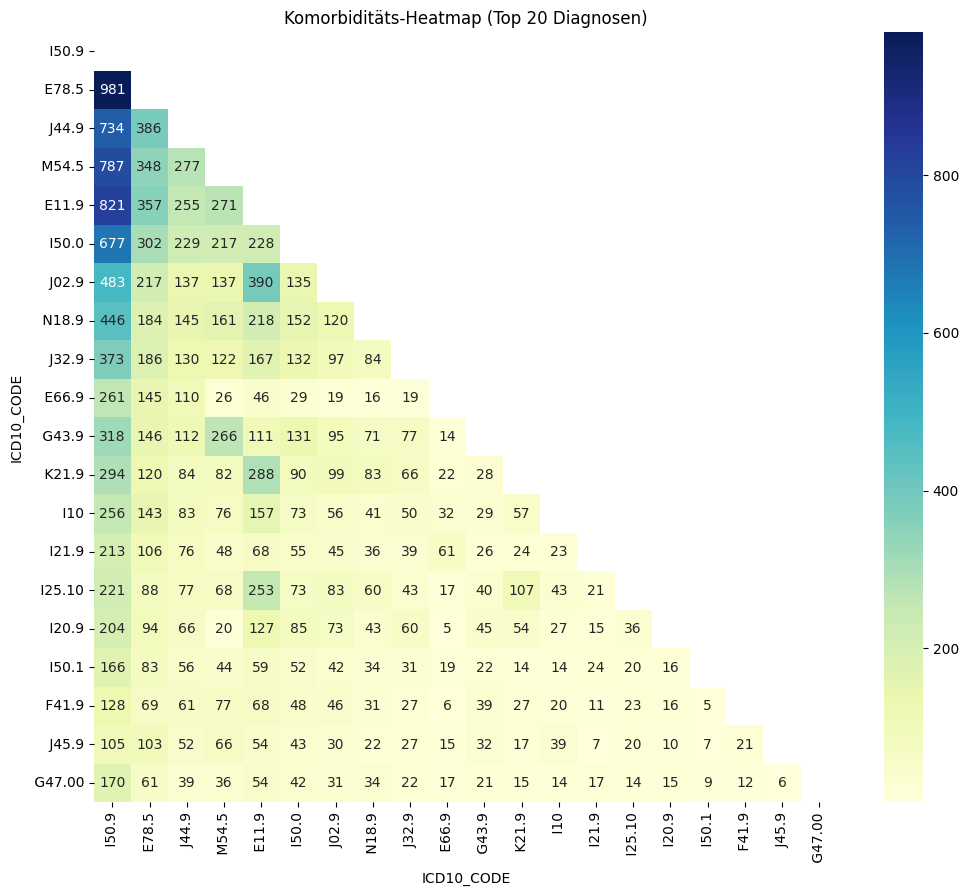

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_matrix = df_conditions.pivot_table(
    index='PATIENT_ID',
    columns='ICD10_CODE',
    aggfunc='size',
    fill_value=0
)
top_codes = df_conditions['ICD10_CODE'].value_counts().head(20).index
df_matrix = df_matrix[top_codes]

co_matrix = df_matrix.T.dot(df_matrix)

# Untere Dreiecksmatrix (ohne Diagonale)
mask = np.triu(np.ones_like(co_matrix, dtype=bool))
co_matrix_masked = co_matrix.mask(mask)

plt.figure(figsize=(12,10))
sns.heatmap(co_matrix_masked, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Komorbiditäts-Heatmap (Top 20 Diagnosen)")
plt.show()